## TensorFlow 2 ResNet 模型训练 


In [1]:
!wget https://pinlandata.blob.core.windows.net/pinlan-data-hub/%E5%A4%96%E5%8C%85%E9%87%87%E9%9B%86/0524%E5%88%86%E7%B1%BB%E6%95%B0%E6%8D%AE%E9%9B%86/%E7%99%BD%E9%85%92%E5%88%86%E7%B1%BB%E6%95%B0%E6%8D%AE%E9%9B%860524.zip

--2020-07-05 06:43:24--  https://pinlandata.blob.core.windows.net/pinlan-data-hub/%E5%A4%96%E5%8C%85%E9%87%87%E9%9B%86/0524%E5%88%86%E7%B1%BB%E6%95%B0%E6%8D%AE%E9%9B%86/%E7%99%BD%E9%85%92%E5%88%86%E7%B1%BB%E6%95%B0%E6%8D%AE%E9%9B%860524.zip
Resolving pinlandata.blob.core.windows.net (pinlandata.blob.core.windows.net)... 52.239.128.36
Connecting to pinlandata.blob.core.windows.net (pinlandata.blob.core.windows.net)|52.239.128.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 232925795 (222M) [application/zip]
Saving to: ‘白酒分类数据集0524.zip’

白酒分类数据集0524. 100%[===================>] 222.13M  4.59MB/s    in 43s     

2020-07-05 06:44:07 (5.21 MB/s) - ‘白酒分类数据集0524.zip’ saved [232925795/232925795]



### 数据集准备

In [1]:
cate = "classified"
# 数据路径
dataset_path = f"data/{cate}"
# 训练集路径
train_dataset_path = f"{dataset_path}/train"
# 验证集路径
val_dataset_path = f"{dataset_path}/val"

In [3]:
# 划分数据集（首次执行）
from data_prep.dataset import Dataset
# 训练和验证集比例
train_ratio = 0.9

data_loader = Dataset(dataset_path, train_ratio=train_ratio) 

In [32]:
# 提取类别名称
import os
class_name = list(
    filter(
        lambda x: not x.startswith(".")
        and os.path.isdir(os.path.join(train_dataset_path, x)),
        os.listdir(train_dataset_path),
    )
)
print(f"类别总数：{len(class_name)}")

类别总数：166


In [6]:
# class_name

### 模型准备

In [3]:
model = "ResNet50"
model_name = f"{model}_{cate}"
model_path = f"models/{model}/{model_name}.h5"

In [4]:
from tensorflow import keras as keras
from PIL import Image

import tensorflow as tf
import numpy as np

keras.backend.clear_session()  # For easy reset of notebook state.

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(devices=gpus[0], device_type="GPU")

In [34]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(include_top=False, weights='imagenet', classes=1000)
base_model.trainable = False

In [35]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import Model

x = base_model.output
x = GlobalAveragePooling2D()(x) 
x = Dense(1024, activation='relu')(x) 
x = Dense(1024, activation='relu')(x) 
y = Dense(len(class_name), activation='softmax')(x) #final layer with softmax activation

model = Model(inputs=base_model.input, outputs=y, name=model_name)

In [7]:
# model.summary()

### 定义优化器和损失函数

In [36]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

### 数据生成器

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing import image


train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
        train_dataset_path,
        target_size=(224,224),
        classes=class_name,
        color_mode='rgb',
        batch_size=128,
        class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
        val_dataset_path,
        target_size=(224,224),
        classes=class_name,
        color_mode='rgb',
        batch_size=128,
        class_mode='categorical')

Found 7167 images belonging to 166 classes.
Found 870 images belonging to 166 classes.


### 设置 EarlyStoping 条件

In [38]:
from tensorflow.keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor="val_loss", patience=3, verbose=1)

### 开始训练

In [39]:
history = model.fit(
        train_generator,
        epochs=20,
        steps_per_epoch=100,
        validation_data=val_generator,
        validation_steps=10,
        callbacks=earlystop)

Epoch 1/20
100/100 [==============================] - 31s 308ms/step - loss: 3.7494 - accuracy: 0.1967 - val_loss: 3.3161 - val_accuracy: 0.2488
Epoch 2/20
100/100 [==============================] - 29s 291ms/step - loss: 2.7425 - accuracy: 0.3536 - val_loss: 2.6917 - val_accuracy: 0.3575
Epoch 3/20
100/100 [==============================] - 29s 291ms/step - loss: 2.1691 - accuracy: 0.4703 - val_loss: 2.2621 - val_accuracy: 0.4553
Epoch 4/20
100/100 [==============================] - 29s 290ms/step - loss: 1.8078 - accuracy: 0.5400 - val_loss: 2.0283 - val_accuracy: 0.5277
Epoch 5/20
100/100 [==============================] - 29s 291ms/step - loss: 1.5624 - accuracy: 0.6008 - val_loss: 1.8784 - val_accuracy: 0.5694
Epoch 6/20
100/100 [==============================] - 29s 290ms/step - loss: 1.3243 - accuracy: 0.6553 - val_loss: 1.7838 - val_accuracy: 0.5953
Epoch 7/20
100/100 [==============================] - 29s 292ms/step - loss: 1.1782 - accuracy: 0.6917 - val_loss: 1.6543 - val_ac

### 模型评估

In [57]:
model.evaluate(
        val_generator,
        steps=10,
        callbacks=earlystop,
        verbose=1)

10/10 [==============================] - 2s 237ms/step - loss: 1.5285 - accuracy: 0.7169


[1.5284998416900635, 0.7169058918952942]

### 保存模型

In [58]:
model.save(model_path)

### 加载模型

In [59]:
model = tf.keras.models.load_model(model_path)

### 单张预测

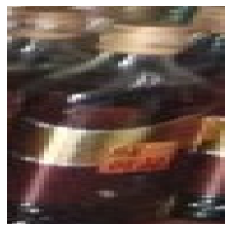

['一品苏黄']


In [60]:
from matplotlib import pyplot as plt

def load_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    
    img_tensor = np.expand_dims(img_tensor, axis=0)         
    img_tensor /= 255.                                      

    plt.imshow(img_tensor[0])                           
    plt.axis('off')
    plt.show()

    return img_tensor

img_path = 'data/classified/val/一品苏黄/1103_18327.jpg'
img_tensor = load_image(img_path)

pred = model.predict(img_tensor)

# print([[class_name[i], prob] for i, prob in enumerate(pred[0])])
print([class_name[np.argmax(prob)] for prob in pred])

In [65]:
class_name[np.argmax(pred[0])]

'一品苏黄'

### 批量预测

In [66]:
from tensorflow.keras.preprocessing import image
import numpy as np

# 加载一批图像
def load_image_list(test_dir):
    image_tensor_list = []    
    image_list = [os.path.join(test_dir, img_name) for img_name in os.listdir(test_dir)]
    for image_path in image_list:
        img = image.load_img(image_path, target_size=(224, 224))
        img_tensor = image.img_to_array(img)                    
        img_tensor = np.expand_dims(img_tensor, axis=0)         
        img_tensor /= 255.
        image_tensor_list.append(img_tensor.reshape(224,224,3))

    return np.asarray(image_tensor_list)

In [67]:
img_list = load_image_list("data/classified/val/一品苏黄/")
preds = model.predict_on_batch(img_list)
results = [class_name[np.argmax(prob)] for prob in preds]
print(results)

['牛栏山43度珍品陈酿白酒500ml', '江小白40度JOYYOUTH500ml', '一品苏黄', '一品苏黄', '江小白40度JOYYOUTH500ml', '小郎酒45度炫彩小瓶100ml', '一品苏黄', '红星二锅头43度绵柔8陈酿500ml', '牛栏山42度陈酿白酒750ml', '一品苏黄', '一品苏黄']


### 计算 Top-1 / Top-5 Acc

In [53]:
top1_corrects = 0
top5_corrects = 0
total = 0

acc = {
    "class_name": class_name,
    "top1": [],
    "top5": [],
}

for idx, cls_name in enumerate(class_name):
    t1, t5 = 0, 0
    test_dir = f"{val_dataset_path}/{cls_name}"
    img_list = load_image_list(test_dir)
    if len(img_list) > 0:
        preds = model.predict_on_batch(img_list)
        total += len(preds)
        for pred in preds:          
            top_ids = pred.argsort()[-5:][::-1]
            if idx == top_ids[0]:
                top1_corrects += 1
                t1 += 1
            if idx in top_ids:
                top5_corrects += 1
                t5 += 1
    acc["top1"].append(t1/len(preds))
    acc["top5"].append(t5/len(preds))
                
print(f"Top-1 Acc: {top1_corrects/total}")
print(f"Top-5 Acc: {top5_corrects/total}")
print(f"Total testing images: {total}")

Top-1 Acc: 0.23218390804597702
Top-5 Acc: 0.44022988505747124
Total testing images: 870


In [51]:
len(class_name)

166